# Predicting life of components: A simple Probabilistic Crack propagation example

Predicting the life of a component that is prone to cracking is an age-old problem that has been studied ad-nauseam by the [fracture mechanics community](https://www.google.com/search?tbm=bks&q=fracture+mechanics).  [Crack propagation models](https://en.wikipedia.org/wiki/Fracture_mechanics) reside at the core of Prognostics and Health Management (PHM) solutions for engineering systems and the aptly titled book [Prognostics and Health Management of Engineering Systems: An Introduction](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) provides a great example of how real world data is used to calibrate engineering models, turning them into Digital Twins. The following example is the most straight forward application of combining probabilistic learning techniques and engineering domain models. 

The most common form of describing a crack propagation is through the Paris Model for fatigue crack growth, which describes the rate of growth $da/dN$ as a function of crack size $a$ and the stress intensity $\Delta\sigma\sqrt{\pi a}$ related to the loading cycle.

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$

Which a very clever engineer can integrate to arrive at a analytical formulation for the size of a crack as a function of the loading cycle at application:

$a(N)=[NC(1-\frac{m}2)(\Delta\sigma\sqrt{\pi})^m+a_0^{1-\frac{m}2}]^\frac2{2-m}$

 The parameters $C$ and $m$ are then left be be calibrated at each application, given the presence of crack size data. Such data is usually obtained during maintenance and inspections of engineering systems. Luckily enough, the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) provides us with such sample dataset. With that in hands, a probabilistic calibration of $C$ and $m$ becomes simple with Tensorflow Probability.

First we need to set up an environment to do so. At BHGE Digital we leverage our [Depend-on-Docker](https://github.com/bhgedigital/depend-on-docker) automation project to wrap the execution of python code in Docker containers. A sample of such automation is available [here](https://github.com/bhgedigital/bayesian_calibration), where a complete version of the following code is available. 

Then, within the python environment we need to import some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow_probability.python.mcmc import util as mcmc_util
import time
import math 

### Setting up the data

Setting up the data for the calibration comes next. Here we leverage the dataset provided in the Table 4.2 of the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false):

In [2]:
# true values of the parameters
t = np.arange(0,1600, 100) #cycles
y = [0.0100,0.0109,0.0101,0.0107,0.0110,0.0123,0.0099,0.0113, 
   0.0132,0.0138,0.0148,0.0156,0.0155,0.0141,0.0169,0.0168] # measured crack size data

### Priors

With the data set ready, we now define the prior distributions for the calibration variables. In a real application, these priors can be informed by a subject matter expert opinion. For this case, we will assume that both $C$ and $m$ are expected to follow Gaussian distributions.


In [3]:
prio_par_C = [-23.0, 1.1] # [location, scale] for Normal Prior
prio_par_m = [4.0, 0.2] # [location, scale] for Normal Prior
rv_m = tfd.Normal(loc = 0.0, scale = 1.0, name = 'm_norm') # Random variable m definition
rv_C = tfd.Normal(loc = 0.0, scale = 1.0, name = 'C_norm') # Random variable logC definition

### Log-prob function

We have defined external parameters and Standard Normal distribution for both variables, just to sample from a normalized space. Therefore, we will need to de-normalize both random variables when computing the crack model.

Now we define the joint log probability for the random variables being calibrated and the associated crack model. 


In [4]:
def joint_logprob(cycles, observations, y0, C_norm, m_norm):
    # Joint logProbability function for both random variables and observations.
    # Some constants
    dsig = 75.0
    B = tf.constant(dsig*math.sqrt(math.pi), tf.float32)
    # Computing m and logC on original space
    C = C_norm*tf.sqrt(prio_par_C[1]) + prio_par_C[0] # 
    m = m_norm*tf.sqrt(prio_par_m[1]) + prio_par_m[0]
    
    # Crack Propagation model - compute in the log space
    y_model = (2.0/(2.0-m))*tf.log(cycles*tf.exp(C)*(1-m/2.0)*tf.pow(B,m) + tf.pow(y0, 1-m/2.0) )
    
    # Defining child model random variable
    rv_model = tfd.Independent(tfd.LogNormal(loc = y_model, scale = 0.1),
                                reinterpreted_batch_ndims=1, name = 'model')
    # Sum of logProbabilities
    sum_log_prob = rv_C.log_prob(C_norm) + rv_m.log_prob(m_norm) + rv_model.log_prob(observations)
    return sum_log_prob

### Sampler

Finally, it is time to set up the sampler and run a Tensorflow session:

In [5]:
# Number of samples and burnin for the MCMC sampler
samples = 12000
burnin = 8000
# Initial state for the HMC
initial_state = [0.0,0.0]
# Converting the data into tensors
cycles = tf.convert_to_tensor(t,tf.float32)
observations = tf.convert_to_tensor(y,tf.float32)
y0 = tf.convert_to_tensor(y[0], tf.float32)
# Setting up a target posterior for our joint logprobability
unormalized_target_posterior= lambda *args: joint_logprob(cycles, observations, y0, *args)
# And finally setting up the mcmc sampler
[C_samples,m_samples], kernel_results = tfp.mcmc.sample_chain(num_results= samples, num_burnin_steps= burnin,
                                                               current_state=initial_state,
                                                              kernel= tfp.mcmc.HamiltonianMonteCarlo(
                                                                      target_log_prob_fn=unormalized_target_posterior,
                                                                      step_size = 0.06, 
                                                                      num_leapfrog_steps=6))


# Tracking the acceptance rate for the sampled chain
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.is_accepted))

# Actually running the sampler
with tf.Session() as sess:
    [C_samples_, m_samples_, acceptance_rate_] = sess.run([C_samples, m_samples, acceptance_rate])

# Some initial results
print('acceptance_rate:', acceptance_rate_)

acceptance_rate: 0.739


### Plotting Results

If everything has gone according to plan, at this point we will see a acceptance rate of the sampler of around 60%. Pretty good for our first bayesian hierarchical crack propagation model. A key metric for the HMC sampler are the sampled chains themselves, which should look mixed and not like a correlated random walk. In this case, our sampler did pretty good: 

Text(0.5,1,'m samples')

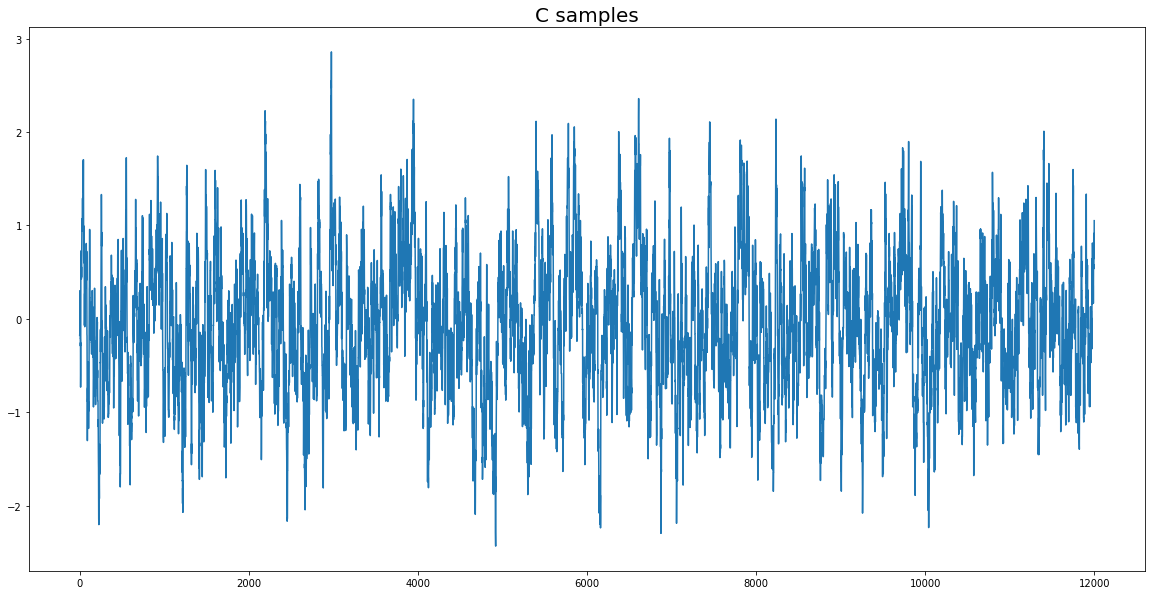

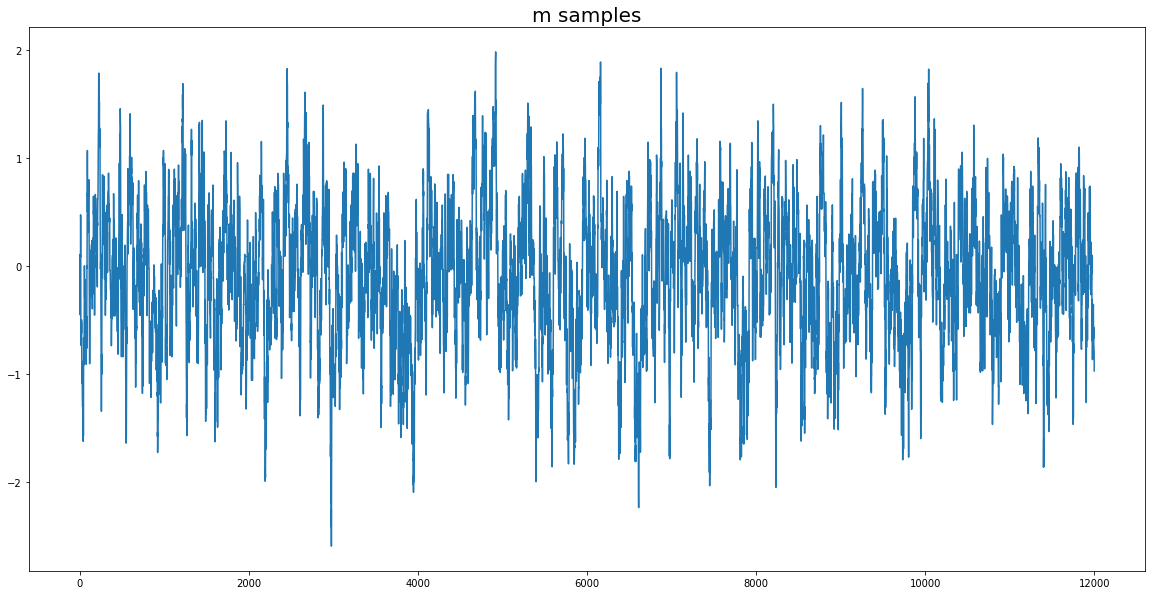

In [6]:
# plotting the mcmc chains
plt.figure(figsize=(20,10))
plt.plot(np.arange(samples), C_samples_)
plt.title('C samples',fontsize=20)

plt.figure(figsize=(20,10))
plt.plot(np.arange(samples), m_samples_)
plt.title('m samples',fontsize=20)



If we collect our sample and rescale them to the original space, we can get some summary statistics on the posterior estimates of the calibrated parameters $\log(C)$ and $m$ and take a look at the distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee07bacf8>,
      dtype=object)

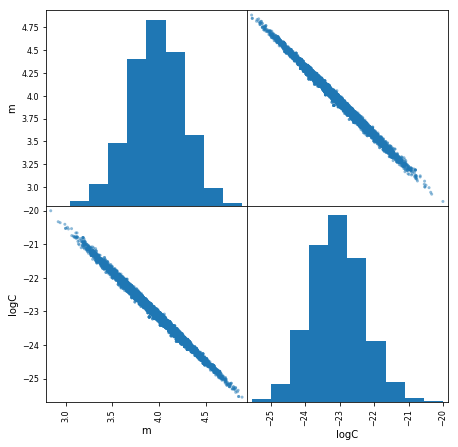

In [7]:
# Converting to proper scale
C_samples_scale = C_samples_*np.sqrt(prio_par_C[1]) + prio_par_C[0]
m_samples_scale = m_samples_*np.sqrt(prio_par_m[1]) + prio_par_m[0]
df = pd.DataFrame(np.concatenate([m_samples_scale[:,None], C_samples_scale[:,None]], axis = 1), columns = ['m', 'logC'])
pd.plotting.scatter_matrix(df,figsize=(7.2,7.2))

In [8]:
df.describe(percentiles=[.05, .95])

,m,logC
count,12000.000000,12000.000000
mean,3.966898,-23.071489
std,0.281993,0.756059
min,2.842102,-25.550751
5%,3.489052,-24.260055
50%,3.971662,-23.078658
95%,4.413624,-21.784454
max,4.884949,-20.002333


### Sampling the Posterior for Prognostic

And now for the final act, we shall define a posterior function for our probabilistic crack propagation model, in order to finaly make the prognostic:

In [9]:
def posterior(C_samples, m_samples, time):
    n_s = len(C_samples)
    n_inputs = len(time)
    
    # Some Constants
    dsig = 75.0
    B = tf.constant(dsig*math.sqrt(math.pi), tf.float32)
    
    # Crack Propagation model - compute in the log space
    
    y_model = (2.0/(2.0-m_samples[None,:]))*tf.log(time[:,None]*tf.exp(C_samples[None,:])*(1-m_samples[None,:]/2.0)*tf.pow(B,m_samples[None,:]) +
                       tf.pow(y0, 1-m_samples[None,:]/2.0))
    
    #y_model = tf.convert_to_tensor(y_model, tf.float32)
    rv_model = tfd.Independent(tfd.LogNormal(loc = y_model, scale = 0.1),
                                reinterpreted_batch_ndims=1, name = 'model')
    samples = rv_model.sample(1)
    with tf.Session() as sess:
        samples_ = sess.run(samples)
    
    return samples_

In [10]:
time = np.arange(0,3500,100)
y_samples = posterior(C_samples_scale, m_samples_scale, time)[0]
print(y_samples.shape)

(35, 12000)


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


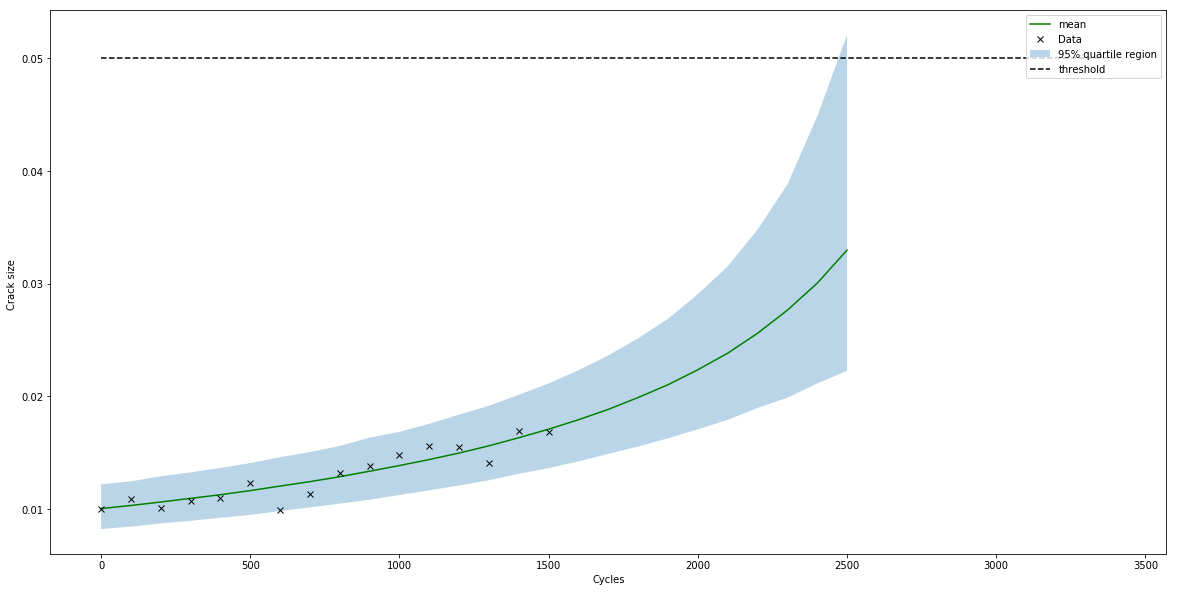

In [11]:
lower_per = np.percentile(y_samples,2.5, axis = 1)
upper_per = np.percentile(y_samples,97.5, axis = 1)

plt.figure(figsize =(20,10))
plt.plot(time, np.mean(y_samples,axis=1), 'g', label = 'mean')
plt.plot(t,y,'kx', label = 'Data')
plt.fill_between(time, lower_per, upper_per, label = '95% quartile region', alpha = 0.3)
plt.xlabel('Cycles')
plt.ylabel('Crack size ')
plt.hlines(0.05, np.min(time), np.max(time), linestyles = '--', label = 'threshold')
plt.legend()